In [1]:
import os
from pathlib import Path
import six.moves.urllib as urllib
import sys
import tarfile
import time

import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/seanmerrifield/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# sys.path.append("..")
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/Users/seanmerrifield/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Set File Paths

In [4]:
# What model to download.
DATA_DIR = str(Path.cwd() / 'models')
IMAGE_DIR = str(Path.cwd() / 'images')
TRAIN_DIR = str(Path.cwd() / 'training')
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_178'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#Dir path where model data will be stored
MODEL_DIR = str(Path(DATA_DIR, MODEL_NAME))
if not Path(MODEL_DIR).is_dir(): Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
    
    
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = str(Path(TRAIN_DIR, 'inference_graph', 'frozen_inference_graph.pb'))

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = str(Path(TRAIN_DIR, 'label_map.pbtxt'))

## Get Label Mappings

In [5]:
# Number of classes the object detector can identify
NUM_CLASSES = 6

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Download Model

In [6]:
if not Path(PATH_TO_FROZEN_GRAPH).exists():
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, str(Path(DATA_DIR, MODEL_FILE)))
    tar_file = tarfile.open(str(Path(DATA_DIR, MODEL_FILE)))
    tar_file.extractall(DATA_DIR)
#     for file in tar_file.getmembers():
#       file_name = os.path.basename(file.name)
#       if 'frozen_inference_graph.pb' in file_name:
#         tar_file.extract(file, DATA_DIR)

## Load Model into Graph

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    sess = tf.Session(graph = detection_graph)

In [8]:
# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')


## Run Inference

In [9]:
def process_image(path):
    # Load image using OpenCV and
    # expand image dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    image = cv.imread(path)
    if image is None or image.size == 0: return None 
    
    copied_image = np.copy(image)
    copied_image = cv.cvtColor(copied_image, cv.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image, axis=0)
    plt.imshow(copied_image)
    return image_expanded

Image took 9.750680208206177 seconds to process


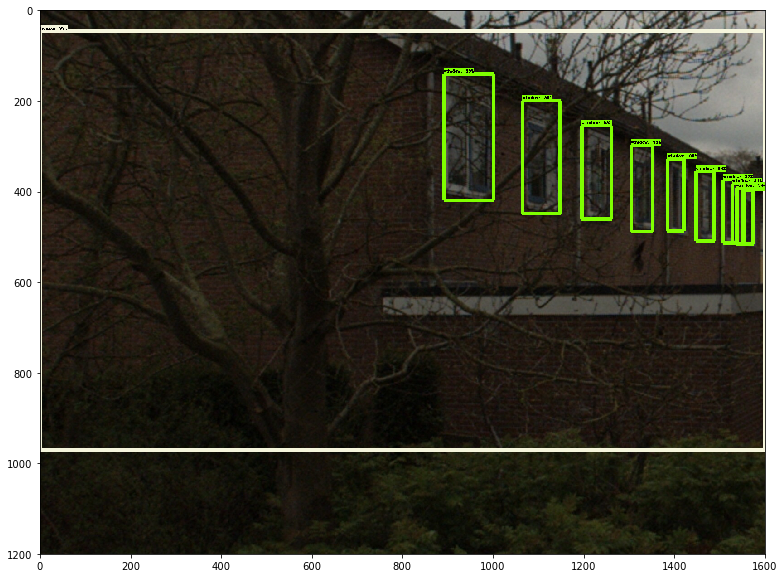

In [10]:
for PATH_TO_IMAGE in Path(IMAGE_DIR).glob('**/*'):
    if not PATH_TO_IMAGE.is_file(): continue
    PATH_TO_IMAGE = str(PATH_TO_IMAGE)
    
    #Read in image
    image = cv.imread(PATH_TO_IMAGE)
    if image is None or image.size == 0: continue
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_expanded = np.expand_dims(image, axis=0)
#     image_expanded = image
    
    start_time = time.time()
    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})
    end_time = time.time()
    
    print("Image took %s seconds to process"%(end_time-start_time))
    
    vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.80)

    fig, ax = plt.subplots(figsize=(18, 10))
    ax.imshow(image, interpolation='nearest')
    break

In [11]:

# Initialize webcam feed
video = cv.VideoCapture(0)
ret = video.set(3,1280)
ret = video.set(4,720)

while(True):

    # Acquire frame and expand frame dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    ret, frame = video.read()
    frame_expanded = np.expand_dims(frame, axis=0)

    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: frame_expanded})

    # Draw the results of the detection (aka 'visulaize the results')
    vis_util.visualize_boxes_and_labels_on_image_array(
        frame,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8,
        min_score_thresh=0.60)

    # All the results have been drawn on the frame, so it's time to display it.
    cv.imshow('Object detector', frame)

    # Press 'q' to quit
    if cv.waitKey(1) == ord('q'):
        break

# Clean up
video.release()
cv.destroyAllWindows()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'